# Capstone Project - The Battle of the Neighborhoods

In this project I will investigate crime rates in San Francisco to identify:
- the areas which are most dangerous (highest crime rates),
- if there is a correlation between crime rates and police station presence,


The project will utilise the San Francisco crime dataset used during the Coursera Python course, along with the Foursquare API to access location data for San Fran police stations.


There are a number of assumptions being made in this analysis:
1. All police stations retrieved by the Foursquare API are actual, functioning police stations (unless known otherwise)
2. All police stations are opened 24 hours
3. Trends in crime rates have no changed materially since 2016


## Part 1: Setup & Inputs

In the first part of this analysis we will be importing and gathering the required data. Each step will be commented to explain what is being done. There are 3 main steps here:
- Standard setups (libraries etc)
- Crime Rate Data
- Police Station data

### Standard Setup

In [7]:
#Import required libraries
!pip install pandas
!pip install folium
!pip install scipy

import pandas as pd
import numpy as np
import folium
import requests
import json
import seaborn as sns

from scipy import stats
from folium import plugins

#Import geojson file for mapping PD districts
#downloaded from https://data.sfgov.org/Public-Safety/Current-Police-Districts/wkhw-cjsf
pd_district_geo = '.../Current Police Districts.geojson' 

In [3]:
!conda install shapely

from shapely.geometry import Point, Polygon

Solving environment: ...working... done

# All requested packages already installed.



### Create Map of San Francisco

In [24]:
#Create map of San Francisco
sf_lat = 37.7649
sf_long = -122.4194
map_sf=folium.Map(location=[sf_lat,sf_long],zoom_start=12)

#Add police department districts from geojson file

folium.GeoJson(open(pd_district_geo).read()).add_to(map_sf)
map_sf

### Import Crime Data

In [10]:
#Import San Francisco Crime data
df_incidents = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DV0101EN-SkillsNetwork/Data%20Files/Police_Department_Incidents_-_Previous_Year__2016_.csv')

print('Dataset downloaded and read into a pandas dataframe!'
     ,'Shape= ',df_incidents.shape)

Dataset downloaded and read into a pandas dataframe! Shape=  (150500, 13)


We now have the San Francisco crime data in a workable data frame. We will wrangle and tidy up the data in Part 2.

### Foursquare API call - Police Station data

In [11]:
#Check latest date of incident data in order to call Foursquare API for correct time point
max_date=df_incidents['Date'].max()
max_date=max_date[0:10]
API_date=max_date[6:10]+max_date[0:2]+max_date[3:5]
print(API_date)

#Drop Date field from crime rates data
df_incidents.drop(axis=1,columns=['Date'],inplace=True)

20161231


In [40]:
CLIENT_ID = '...' # your Foursquare ID
CLIENT_SECRET = '...' # your Foursquare Secret
VERSION = API_date # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value


# create the API request URL
API_url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&query={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    sf_lat, 
    sf_long, 
    'policestation')
            
    
#print('API_url: ',API_url)

In [13]:
# make the GET request
results = requests.get(API_url).json()["response"]["venues"]
results

[{'id': '4b43f6acf964a52028ef25e3',
  'name': 'Tenderloin Police Station',
  'contact': {},
  'location': {'address': '301 Eddy St',
   'crossStreet': 'at Jones',
   'lat': 37.78382621650408,
   'lng': -122.41293091990042,
   'labeledLatLngs': [{'label': 'display',
     'lat': 37.78382621650408,
     'lng': -122.41293091990042}],
   'distance': 2182,
   'postalCode': '94102',
   'cc': 'US',
   'neighborhood': 'Tenderloin',
   'city': 'San Francisco',
   'state': 'CA',
   'country': 'United States',
   'formattedAddress': ['301 Eddy St (at Jones)',
    'San Francisco, CA 94102',
    'United States']},
  'categories': [{'id': '4bf58dd8d48988d12e941735',
    'name': 'Police Station',
    'pluralName': 'Police Stations',
    'shortName': 'Police Station',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/government_policestation_',
     'suffix': '.png'},
    'primary': True}],
  'verified': False,
  'stats': {'tipCount': 0,
   'usersCount': 0,
   'checkinsCount': 0,


In [14]:
#Extract relevant data into a list
station_list=[]

for item in results:
    my_dict={}
    my_dict['name']=item.get('name')
    my_dict['latitude']=item.get('location').get('lat')
    my_dict['longitude']=item.get('location').get('lng')
    my_dict['address']=item.get('location').get('address')
    my_dict['neighbourhood']=item.get('location').get('neighborhood')
    my_dict['city']=item.get('location').get('city')
    my_dict['postalcode']=item.get('location').get('postalCode')
    my_dict['id']=item.get('id')
    station_list.append(my_dict)

station_list

[{'name': 'Tenderloin Police Station',
  'latitude': 37.78382621650408,
  'longitude': -122.41293091990042,
  'address': '301 Eddy St',
  'neighbourhood': 'Tenderloin',
  'city': 'San Francisco',
  'postalcode': '94102',
  'id': '4b43f6acf964a52028ef25e3'},
 {'name': 'UCSF Police Station Mission Bay',
  'latitude': 37.7674674987793,
  'longitude': -122.39086151123047,
  'address': '600 16th St, Genentech Hall 124',
  'neighbourhood': None,
  'city': 'San Francisco',
  'postalcode': '94158',
  'id': '4e85d2195c5cfedb827a5451'},
 {'name': 'Police Station - Fillmore And Turk',
  'latitude': 37.78041064739227,
  'longitude': -122.4321985244751,
  'address': '1401-1499 Turk St',
  'neighbourhood': None,
  'city': 'San Francisco',
  'postalcode': '94115',
  'id': '4d9cf839a1ec8cfad185f849'},
 {'name': 'Police Station',
  'latitude': 37.77714538574219,
  'longitude': -122.40219116210938,
  'address': '70 Oak Grove St',
  'neighbourhood': None,
  'city': 'San Francisco',
  'postalcode': '94107

We now have a data frame listing all the police stations in San Francisco, along with their geographical coordinates. We will wrangle and tidy up this data in Part 2.

## Part 2: Data Cleansing/Wrangling

In the second part of this analysis the crime data and police station data will be manipulated and cleansed to get it into a format which will help us gain a more intuitive insight into the relationship between crime rates and police stations.

### Police Station Data

In [15]:
#Create data frame from station list
from pandas import DataFrame

results=DataFrame(station_list)
print('Initial data: ',results.shape)

#Drop entries deemed not to be valid operating police stations
#Not in San Fran
results.drop(results[results['city']!='San Francisco'].index,inplace=True)
print('Drop stations outside San Fran: ',results.shape)
#Community room - not a station
results.drop(results[results['name']=='Richmond Police Station Community Room'].index,inplace=True)
#Not in use any more
results.drop(results[results['name']=='Old Mission Police Station'].index,inplace=True)
print('Drop invalid stations: ',results.shape)

#Drop unnecessary fields
results.drop(axis=1,columns=['address','city','postalcode','id'],inplace=True)
results.reset_index(drop=True,inplace=True)
print('Drop unnecessary fields: ',results.shape)

#Add coordinates field
results['coordinates']=list(zip(results['longitude'],results['latitude']))
print('Add coordinates: ',results.shape)

results

Initial data:  (30, 8)
Drop stations outside San Fran:  (18, 8)
Drop invalid stations:  (16, 8)
Drop unnecessary fields:  (16, 4)
Add coordinates:  (16, 5)


,name,latitude,longitude,neighbourhood,coordinates
0,Tenderloin Police Station,37.783826,-122.412931,Tenderloin,"(-122.41293091990042, 37.78382621650408)"
1,UCSF Police Station Mission Bay,37.767467,-122.390862,None,"(-122.39086151123047, 37.7674674987793)"
2,Police Station - Fillmore And Turk,37.780411,-122.432199,None,"(-122.4321985244751, 37.78041064739227)"
3,Police Station,37.777145,-122.402191,None,"(-122.40219116210938, 37.77714538574219)"
4,Mission Police Station,37.762975,-122.421723,None,"(-122.4217226613483, 37.76297545942227)"
5,Central District Police Station,37.798528,-122.409704,None,"(-122.4097038099294, 37.798527633554926)"
6,Potrero Hill Police Station,37.751912,-122.400039,None,"(-122.4000391347149, 37.751912434928705)"
7,Park Police Station,37.768003,-122.455309,None,"(-122.45530902147917, 37.768003040827274)"
8,Southern Police Station,37.772420,-122.389336,None,"(-122.38933588503386, 37.77241979763089)"
9,North End Police Station,37.798153,-122.440275,None,"(-122.440275, 37.798153000000006)"


### Crime Data

In [16]:
#Only keep criminal incidents & drop irrelevant columns
df_incidents.rename(columns={'Y':'Latitude','X':'Longitude'},inplace=True)
df_incidents.drop(axis=1,columns=['IncidntNum','DayOfWeek','Time','PdId','Location'],inplace=True)
df_incidents= df_incidents[df_incidents.Category != 'NON-CRIMINAL']
print(df_incidents.shape)
df_incidents.head()

(132634, 7)


,Category,Descript,PdDistrict,Resolution,Address,Longitude,Latitude
0,WEAPON LAWS,POSS OF PROHIBITED WEAPON,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421
1,WEAPON LAWS,"FIREARM, LOADED, IN VEHICLE, POSSESSION OR USE",SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421
2,WARRANTS,WARRANT ARREST,BAYVIEW,"ARREST, BOOKED",KEITH ST / SHAFTER AV,-122.388856,37.729981
5,ASSAULT,BATTERY,NORTHERN,NONE,1700 Block of BUSH ST,-122.426077,37.788019
6,OTHER OFFENSES,PAROLE VIOLATION,SOUTHERN,"ARREST, BOOKED",MARY ST / HOWARD ST,-122.405721,37.780879


In [17]:
#Check number of records in crime dataset before any adjustments
#Check all unique values of Category - types of crime reported
df_incidents.groupby('Category').count().sort_values(by='Descript',ascending=False)
print("Before tidy-up: ",df_incidents.shape)
df_incidents['Category'].unique()

Before tidy-up:  (132634, 7)


array(['WEAPON LAWS', 'WARRANTS', 'ASSAULT', 'OTHER OFFENSES',
       'MISSING PERSON', 'LARCENY/THEFT', 'BURGLARY', 'STOLEN PROPERTY',
       'ROBBERY', 'FRAUD', 'DRUG/NARCOTIC', 'VEHICLE THEFT',
       'RECOVERED VEHICLE', 'VANDALISM', 'ARSON', 'PROSTITUTION',
       'SECONDARY CODES', 'SUSPICIOUS OCC', 'DRUNKENNESS', 'TRESPASS',
       'SEX OFFENSES, NON FORCIBLE', 'SEX OFFENSES, FORCIBLE', 'RUNAWAY',
       'KIDNAPPING', 'DISORDERLY CONDUCT', 'DRIVING UNDER THE INFLUENCE',
       'FORGERY/COUNTERFEITING', 'EMBEZZLEMENT', 'BRIBERY',
       'FAMILY OFFENSES', 'GAMBLING', 'SUICIDE', 'LIQUOR LAWS',
       'EXTORTION', 'LOITERING', 'TREA', 'BAD CHECKS',
       'PORNOGRAPHY/OBSCENE MAT'], dtype=object)

In [18]:
#Not all offences considered relevant for this analysis - only publically occurring crimes of interest e.g. theft, assault, etc.
#to drop:
 #   warrants
 #   suicide
 #   other offenses
 #   Trea
 #   PORNOGRAPHY/OBSCENE MAT
 #   Gambling
 #   BAD CHECKS
 #   FAMILY OFFENSES
 #   EXTORTION
 #   BRIBERY
 #   Runaway
 #   EMBEZZLEMENT
 #   FORGERY/COUNTERFEITING 
 #   RECOVERED VEHICLE 
 #   FRAUD 
 #   SECONDARY CODES

exclusions=['WARRANTS','SUICIDE','OTHER OFFENSES','TREA','PORNOGRAPHY/OBSCENE MAT','GAMBLING','BAD CHECKS','FAMILY OFFENSES',
           'EXTORTION','BRIBERY','RUNAWAY','EMBEZZLEMENT','FORGERY/COUNTERFEITING','RECOVERED VEHICLE','FRAUD',
            'SECONDARY CODES','LIQUOR LAWS']

df_incidents_sub=df_incidents[df_incidents['Category'].isin(exclusions) == False].reset_index(drop=True)
print("After exclusions: ",df_incidents_sub.shape)

#Some categories can be grouped together as they are closely related
#Combine:
 #   Larceny/theft & robbery & stolen property & VEHICLE THEFT & BURGLARY
 #   SEX OFFENSES, NON FORCIBLE & SEX OFFENSES, FORCIBLE

df_incidents_sub['Category'] = np.where((df_incidents_sub.Category == 'LARCENY/THEFT') | 
                                        (df_incidents_sub.Category == 'ROBBERY') |
                                        (df_incidents_sub.Category == 'STOLEN PROPERTY') |
                                        (df_incidents_sub.Category == 'VEHICLE THEFT') |
                                        (df_incidents_sub.Category == 'BURGLARY') ,'THEFT/BURGLARY', df_incidents_sub.Category)

df_incidents_sub['Category'] = np.where((df_incidents_sub.Category == 'SEX OFFENSES, NON FORCIBLE') | 
                                        (df_incidents_sub.Category == 'SEX OFFENSES, FORCIBLE'), 'SEX OFFENSES', df_incidents_sub.Category)

#Check number of observations after exclusions and renaming
#Check all unique values of Category after renaming
print("After renaming: ",df_incidents_sub.shape)
df_incidents_sub['Category'].unique()

After exclusions:  (100517, 7)
After renaming:  (100517, 7)


array(['WEAPON LAWS', 'ASSAULT', 'MISSING PERSON', 'THEFT/BURGLARY',
       'DRUG/NARCOTIC', 'VANDALISM', 'ARSON', 'PROSTITUTION',
       'SUSPICIOUS OCC', 'DRUNKENNESS', 'TRESPASS', 'SEX OFFENSES',
       'KIDNAPPING', 'DISORDERLY CONDUCT', 'DRIVING UNDER THE INFLUENCE',
       'LOITERING'], dtype=object)

In [19]:
#Create list of districts where crimes were reported (ignore missing values)
districts_list=df_incidents_sub['PdDistrict'].unique().tolist()
districts_list = [x for x in districts_list if str(x) != 'nan']
display(districts_list)

#Count number of crime records for each PD District
display(df_incidents_sub.groupby('PdDistrict').count())

['SOUTHERN',
 'NORTHERN',
 'BAYVIEW',
 'TARAVAL',
 'INGLESIDE',
 'CENTRAL',
 'MISSION',
 'RICHMOND',
 'TENDERLOIN',
 'PARK']

,Category,Descript,Resolution,Address,Longitude,Latitude
PdDistrict,,,,,,
BAYVIEW,9347,9347,9347,9347,9347,9347
CENTRAL,12404,12404,12404,12404,12404,12404
INGLESIDE,7578,7578,7578,7578,7578,7578
MISSION,12394,12394,12394,12394,12394,12394
NORTHERN,14425,14425,14425,14425,14425,14425
PARK,5692,5692,5692,5692,5692,5692
RICHMOND,6041,6041,6041,6041,6041,6041
SOUTHERN,19258,19258,19258,19258,19258,19258
TARAVAL,7187,7187,7187,7187,7187,7187


In [20]:
#Create dataframe containing number of crime records for each PD district. 
#This dataframe will be used in the next step to create a heat map of San Francisco crime rates. 
choro_df=df_incidents_sub.groupby('PdDistrict').size().reset_index(name='No. Incidents').sort_values(by='No. Incidents',ascending=False)
choro_df.reset_index(drop=True, inplace=True)
choro_df

,PdDistrict,No. Incidents
0,SOUTHERN,19258
1,NORTHERN,14425
2,CENTRAL,12404
3,MISSION,12394
4,BAYVIEW,9347
5,INGLESIDE,7578
6,TARAVAL,7187
7,TENDERLOIN,6190
8,RICHMOND,6041
9,PARK,5692


#### Conclusion 1: 
We can see from the above table that the most dangerous district or district with the highest crime rate in San Francisco is Southern District, while Park is the safest area. Let's visualise the data in the next step using a scale to show variance in crime rates between districts.

## Part 3: Visualise Data on a Map

In this section we will create a choropleth map to visualise the crime rates in each PD district to identify which district is safest and which has the highest incidence of criminal activity. We will then plot the police station locations and add district labels.

In [25]:
# create a numpy array of length 6 and has linear spacing from the minium total immigration to the maximum total immigration
threshold_scale = np.linspace(choro_df['No. Incidents'].min(),
                              choro_df['No. Incidents'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration

#create choropleth map
choropleth=folium.Choropleth(
    geo_data=pd_district_geo,
    data=choro_df,
    columns=['PdDistrict', 'No. Incidents'],
    key_on='feature.properties.district',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.6, 
    line_opacity=0.2,
    legend_name='Crime Rate in San Francisco'
).add_to(map_sf)

# display map
map_sf

In [29]:
#Add police station locations to the San Francisco map
for lat,long,label in zip(results['latitude'],results['longitude'],results['name']):
    folium.CircleMarker(location=[lat,long],radius=3,color='darkblue',fill=True,fill_color='darkblue',fill_opacity=1,popup=label).add_to(map_sf)
map_sf

In [30]:
#Add region labels to choropleth map
folium.LayerControl().add_to(map_sf)
# Display Region Label
choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['district'], labels=False)
)
map_sf

#### Conclusion 2:
The above map confirms that the Southern district has the highest crime rate and is the only district in the highest crime rate category. Another conclusion is that generally west San Francisco is safer than East San Francisco.

Now let's create a regression plot to see if there is any correlation between crime rates and number of police stations in each distrct.

## Part 4: Regression Plot - Crime Rate vs. No. Police Stations

In this part of the project we will create a regression plot of number of police stations against number of criminal records for each district. We will determing whether a predictive model can be built that will allow us to estimate the crime rate based on the number of police stations in any given area. 

In order to merge the police station and crime rate datasets we need to add a PdDistrict field to the police station dataframe. We will do this by looking at geo coordinates of the police stations being within the specified bounds of each district polygon on the geoojson file.

Once this data wrangling has been completed, we will group count of stations by PD Dsitrict and map to the grouped crime rate dataframe by PD District.

In [31]:
#Extract District name and polygon coordinates from GeoJson file and create a list of district dictionaries
with open(pd_district_geo, mode='r') as f:

    json_data = json.load(f)
    
temp_list=json_data['features']

json_pd_districts=[]

for temp_item in temp_list:
    my_dict={}
    my_dict['district']=temp_item.get("properties").get('district')
    my_dict['polygon']=temp_item.get("geometry").get('coordinates')[0][0]
    json_pd_districts.append(my_dict)

district_list_poly=[]


#Change nested list of polygon coordinates to list of tuples for applying shapely Polygon() conversion 
i=0
while i < len(json_pd_districts):
    row=json_pd_districts[i]
    x=0
    polygon_tuple_list=[]
    while x < len(row['polygon']):
        polygon=row['polygon'][x]
        polygon_tuple=tuple(polygon)
        polygon_tuple_list.append(polygon_tuple)
        
        x=x+1
    row['polygon']=polygon_tuple_list
    json_pd_districts[i]=row

    i=i+1

    
#Create daatframe of districts and corresponding polygon boundaries
polygon_df=pd.DataFrame.from_dict(json_pd_districts)
polygon_df

,district,polygon
0,SOUTHERN,"[(-122.39186138812263, 37.79424680970543), (-1..."
1,BAYVIEW,"[(-122.38098281360058, 37.764800220190175), (-..."
2,MISSION,"[(-122.40953917435229, 37.769317718404), (-122..."
3,NORTHERN,"[(-122.43379217152915, 37.80793010706978), (-1..."
4,TENDERLOIN,"[(-122.40217133081705, 37.786260131123804), (-..."
5,CENTRAL,"[(-122.42612039096105, 37.806838540010546), (-..."
6,PARK,"[(-122.43955630942153, 37.7831382837805), (-12..."
7,RICHMOND,"[(-122.44126871380196, 37.79148984438553), (-1..."
8,INGLESIDE,"[(-122.40449818754264, 37.74858097286839), (-1..."
9,TARAVAL,"[(-122.49841667062083, 37.70810461000542), (-1..."


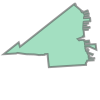

SOUTHERN
POINT (-122.4129309199004 37.78382621650408)
station  0 Tenderloin Police Station  not within poly  0
POINT (-122.3908615112305 37.7674674987793)
station  1 UCSF Police Station Mission Bay  within poly  0
POINT (-122.4321985244751 37.78041064739227)
station  2 Police Station - Fillmore And Turk  not within poly  0
POINT (-122.4021911621094 37.77714538574219)
station  3 Police Station  within poly  0
POINT (-122.4217226613483 37.76297545942227)
station  4 Mission Police Station  not within poly  0
POINT (-122.4097038099294 37.79852763355493)
station  5 Central District Police Station  not within poly  0
POINT (-122.4000391347149 37.75191243492871)
station  6 Potrero Hill Police Station  not within poly  0
POINT (-122.4553090214792 37.76800304082727)
station  7 Park Police Station  not within poly  0
POINT (-122.3893358850339 37.77241979763089)
station  8 Southern Police Station  within poly  0
POINT (-122.440275 37.79815300000001)
station  9 North End Police Station  not within

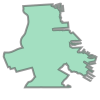

BAYVIEW
POINT (-122.4129309199004 37.78382621650408)
station  0 Tenderloin Police Station  not within poly  1
POINT (-122.3908615112305 37.7674674987793)
station  1 UCSF Police Station Mission Bay  not within poly  1
POINT (-122.4321985244751 37.78041064739227)
station  2 Police Station - Fillmore And Turk  not within poly  1
POINT (-122.4021911621094 37.77714538574219)
station  3 Police Station  not within poly  1
POINT (-122.4217226613483 37.76297545942227)
station  4 Mission Police Station  not within poly  1
POINT (-122.4097038099294 37.79852763355493)
station  5 Central District Police Station  not within poly  1
POINT (-122.4000391347149 37.75191243492871)
station  6 Potrero Hill Police Station  within poly  1
POINT (-122.4553090214792 37.76800304082727)
station  7 Park Police Station  not within poly  1
POINT (-122.3893358850339 37.77241979763089)
station  8 Southern Police Station  not within poly  1
POINT (-122.440275 37.79815300000001)
station  9 North End Police Station  not

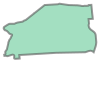

MISSION
POINT (-122.4129309199004 37.78382621650408)
station  0 Tenderloin Police Station  not within poly  2
POINT (-122.3908615112305 37.7674674987793)
station  1 UCSF Police Station Mission Bay  not within poly  2
POINT (-122.4321985244751 37.78041064739227)
station  2 Police Station - Fillmore And Turk  not within poly  2
POINT (-122.4021911621094 37.77714538574219)
station  3 Police Station  not within poly  2
POINT (-122.4217226613483 37.76297545942227)
station  4 Mission Police Station  within poly  2
POINT (-122.4097038099294 37.79852763355493)
station  5 Central District Police Station  not within poly  2
POINT (-122.4000391347149 37.75191243492871)
station  6 Potrero Hill Police Station  not within poly  2
POINT (-122.4553090214792 37.76800304082727)
station  7 Park Police Station  not within poly  2
POINT (-122.3893358850339 37.77241979763089)
station  8 Southern Police Station  not within poly  2
POINT (-122.440275 37.79815300000001)
station  9 North End Police Station  not

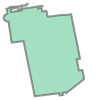

NORTHERN
POINT (-122.4129309199004 37.78382621650408)
station  0 Tenderloin Police Station  not within poly  3
POINT (-122.3908615112305 37.7674674987793)
station  1 UCSF Police Station Mission Bay  not within poly  3
POINT (-122.4321985244751 37.78041064739227)
station  2 Police Station - Fillmore And Turk  within poly  3
POINT (-122.4021911621094 37.77714538574219)
station  3 Police Station  not within poly  3
POINT (-122.4217226613483 37.76297545942227)
station  4 Mission Police Station  not within poly  3
POINT (-122.4097038099294 37.79852763355493)
station  5 Central District Police Station  not within poly  3
POINT (-122.4000391347149 37.75191243492871)
station  6 Potrero Hill Police Station  not within poly  3
POINT (-122.4553090214792 37.76800304082727)
station  7 Park Police Station  not within poly  3
POINT (-122.3893358850339 37.77241979763089)
station  8 Southern Police Station  not within poly  3
POINT (-122.440275 37.79815300000001)
station  9 North End Police Station  wi

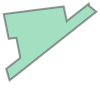

TENDERLOIN
POINT (-122.4129309199004 37.78382621650408)
station  0 Tenderloin Police Station  within poly  4
POINT (-122.3908615112305 37.7674674987793)
station  1 UCSF Police Station Mission Bay  not within poly  4
POINT (-122.4321985244751 37.78041064739227)
station  2 Police Station - Fillmore And Turk  not within poly  4
POINT (-122.4021911621094 37.77714538574219)
station  3 Police Station  not within poly  4
POINT (-122.4217226613483 37.76297545942227)
station  4 Mission Police Station  not within poly  4
POINT (-122.4097038099294 37.79852763355493)
station  5 Central District Police Station  not within poly  4
POINT (-122.4000391347149 37.75191243492871)
station  6 Potrero Hill Police Station  not within poly  4
POINT (-122.4553090214792 37.76800304082727)
station  7 Park Police Station  not within poly  4
POINT (-122.3893358850339 37.77241979763089)
station  8 Southern Police Station  not within poly  4
POINT (-122.440275 37.79815300000001)
station  9 North End Police Station  

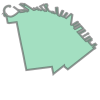

CENTRAL
POINT (-122.4129309199004 37.78382621650408)
station  0 Tenderloin Police Station  not within poly  5
POINT (-122.3908615112305 37.7674674987793)
station  1 UCSF Police Station Mission Bay  not within poly  5
POINT (-122.4321985244751 37.78041064739227)
station  2 Police Station - Fillmore And Turk  not within poly  5
POINT (-122.4021911621094 37.77714538574219)
station  3 Police Station  not within poly  5
POINT (-122.4217226613483 37.76297545942227)
station  4 Mission Police Station  not within poly  5
POINT (-122.4097038099294 37.79852763355493)
station  5 Central District Police Station  within poly  5
POINT (-122.4000391347149 37.75191243492871)
station  6 Potrero Hill Police Station  not within poly  5
POINT (-122.4553090214792 37.76800304082727)
station  7 Park Police Station  not within poly  5
POINT (-122.3893358850339 37.77241979763089)
station  8 Southern Police Station  not within poly  5
POINT (-122.440275 37.79815300000001)
station  9 North End Police Station  not

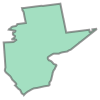

PARK
POINT (-122.4129309199004 37.78382621650408)
station  0 Tenderloin Police Station  not within poly  6
POINT (-122.3908615112305 37.7674674987793)
station  1 UCSF Police Station Mission Bay  not within poly  6
POINT (-122.4321985244751 37.78041064739227)
station  2 Police Station - Fillmore And Turk  not within poly  6
POINT (-122.4021911621094 37.77714538574219)
station  3 Police Station  not within poly  6
POINT (-122.4217226613483 37.76297545942227)
station  4 Mission Police Station  not within poly  6
POINT (-122.4097038099294 37.79852763355493)
station  5 Central District Police Station  not within poly  6
POINT (-122.4000391347149 37.75191243492871)
station  6 Potrero Hill Police Station  not within poly  6
POINT (-122.4553090214792 37.76800304082727)
station  7 Park Police Station  within poly  6
POINT (-122.3893358850339 37.77241979763089)
station  8 Southern Police Station  not within poly  6
POINT (-122.440275 37.79815300000001)
station  9 North End Police Station  not wi

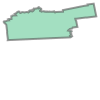

RICHMOND
POINT (-122.4129309199004 37.78382621650408)
station  0 Tenderloin Police Station  not within poly  7
POINT (-122.3908615112305 37.7674674987793)
station  1 UCSF Police Station Mission Bay  not within poly  7
POINT (-122.4321985244751 37.78041064739227)
station  2 Police Station - Fillmore And Turk  not within poly  7
POINT (-122.4021911621094 37.77714538574219)
station  3 Police Station  not within poly  7
POINT (-122.4217226613483 37.76297545942227)
station  4 Mission Police Station  not within poly  7
POINT (-122.4097038099294 37.79852763355493)
station  5 Central District Police Station  not within poly  7
POINT (-122.4000391347149 37.75191243492871)
station  6 Potrero Hill Police Station  not within poly  7
POINT (-122.4553090214792 37.76800304082727)
station  7 Park Police Station  not within poly  7
POINT (-122.3893358850339 37.77241979763089)
station  8 Southern Police Station  not within poly  7
POINT (-122.440275 37.79815300000001)
station  9 North End Police Station

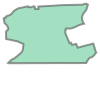

INGLESIDE
POINT (-122.4129309199004 37.78382621650408)
station  0 Tenderloin Police Station  not within poly  8
POINT (-122.3908615112305 37.7674674987793)
station  1 UCSF Police Station Mission Bay  not within poly  8
POINT (-122.4321985244751 37.78041064739227)
station  2 Police Station - Fillmore And Turk  not within poly  8
POINT (-122.4021911621094 37.77714538574219)
station  3 Police Station  not within poly  8
POINT (-122.4217226613483 37.76297545942227)
station  4 Mission Police Station  not within poly  8
POINT (-122.4097038099294 37.79852763355493)
station  5 Central District Police Station  not within poly  8
POINT (-122.4000391347149 37.75191243492871)
station  6 Potrero Hill Police Station  not within poly  8
POINT (-122.4553090214792 37.76800304082727)
station  7 Park Police Station  not within poly  8
POINT (-122.3893358850339 37.77241979763089)
station  8 Southern Police Station  not within poly  8
POINT (-122.440275 37.79815300000001)
station  9 North End Police Statio

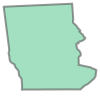

TARAVAL
POINT (-122.4129309199004 37.78382621650408)
station  0 Tenderloin Police Station  not within poly  9
POINT (-122.3908615112305 37.7674674987793)
station  1 UCSF Police Station Mission Bay  not within poly  9
POINT (-122.4321985244751 37.78041064739227)
station  2 Police Station - Fillmore And Turk  not within poly  9
POINT (-122.4021911621094 37.77714538574219)
station  3 Police Station  not within poly  9
POINT (-122.4217226613483 37.76297545942227)
station  4 Mission Police Station  not within poly  9
POINT (-122.4097038099294 37.79852763355493)
station  5 Central District Police Station  not within poly  9
POINT (-122.4000391347149 37.75191243492871)
station  6 Potrero Hill Police Station  not within poly  9
POINT (-122.4553090214792 37.76800304082727)
station  7 Park Police Station  not within poly  9
POINT (-122.3893358850339 37.77241979763089)
station  8 Southern Police Station  not within poly  9
POINT (-122.440275 37.79815300000001)
station  9 North End Police Station 

In [33]:
#Convert district dataframe with polygon coordinates to a dictionary for looping
polygon_dict=polygon_df.to_dict('records')

#Convert station dataframe with coordinates to a dictionary for looping
station_dict=results.to_dict('records')

#Outer loop loops through all districts and created a polygon from the district coordinates
i=0
while i < len(polygon_dict):
    row=polygon_dict[i]
    x=row['polygon']
    district=row['district']
    poly=Polygon(x)
    display(poly)
    print(district)
    
    #Inner loop loops through stations. If station coordinates are within the polygon of the outer loop
    #     the district from outer loop is assigned as the district for the station
    s=0

    while s < len(station_dict):
        point=station_dict[s]['coordinates']
        station=station_dict[s]['name']
        print(Point(point))
        if Point(point).within(poly):
            print('station ',s,station,' within poly ',i)
            station_dict[s]['PdDistrict']=district
        else:
            print('station ',s,station,' not within poly ',i)
            
        #Loop to next station    
        s=s+1
        
    #Loop to next polygon
    i=i+1

In [34]:
#Create data frame from station dictionary which now includes PdDistrict
sf_stations=pd.DataFrame.from_dict(station_dict)
sf_stations

,name,latitude,longitude,neighbourhood,coordinates,PdDistrict
0,Tenderloin Police Station,37.783826,-122.412931,Tenderloin,"(-122.41293091990042, 37.78382621650408)",TENDERLOIN
1,UCSF Police Station Mission Bay,37.767467,-122.390862,None,"(-122.39086151123047, 37.7674674987793)",SOUTHERN
2,Police Station - Fillmore And Turk,37.780411,-122.432199,None,"(-122.4321985244751, 37.78041064739227)",NORTHERN
3,Police Station,37.777145,-122.402191,None,"(-122.40219116210938, 37.77714538574219)",SOUTHERN
4,Mission Police Station,37.762975,-122.421723,None,"(-122.4217226613483, 37.76297545942227)",MISSION
5,Central District Police Station,37.798528,-122.409704,None,"(-122.4097038099294, 37.798527633554926)",CENTRAL
6,Potrero Hill Police Station,37.751912,-122.400039,None,"(-122.4000391347149, 37.751912434928705)",BAYVIEW
7,Park Police Station,37.768003,-122.455309,None,"(-122.45530902147917, 37.768003040827274)",PARK
8,Southern Police Station,37.772420,-122.389336,None,"(-122.38933588503386, 37.77241979763089)",SOUTHERN
9,North End Police Station,37.798153,-122.440275,None,"(-122.440275, 37.798153000000006)",NORTHERN


In [37]:
#Count number of stations in each district
station_count=sf_stations.groupby('PdDistrict').size().reset_index(name='No. Stations').sort_values(by='No. Stations',ascending=False)
station_count.reset_index(drop=True, inplace=True)
station_count

,PdDistrict,No. Stations
0,SOUTHERN,3
1,TARAVAL,3
2,BAYVIEW,2
3,NORTHERN,2
4,CENTRAL,1
5,INGLESIDE,1
6,MISSION,1
7,PARK,1
8,RICHMOND,1
9,TENDERLOIN,1


Now that we have a data frame with the number of stations per district, and we already have a data frame with number of crime incidents per district, we can merge the 2 to get our base dataset for the regression.

In [38]:
#Merge station count and incident count dataframes for regression
reg_df=pd.merge(station_count,choro_df,on=['PdDistrict'])
reg_df

,PdDistrict,No. Stations,No. Incidents
0,SOUTHERN,3,19258
1,TARAVAL,3,7187
2,BAYVIEW,2,9347
3,NORTHERN,2,14425
4,CENTRAL,1,12404
5,INGLESIDE,1,7578
6,MISSION,1,12394
7,PARK,1,5692
8,RICHMOND,1,6041
9,TENDERLOIN,1,6190


Now we have the base data frame we can run the regression on number of stations against number of incidents

R-squared:  23.25%


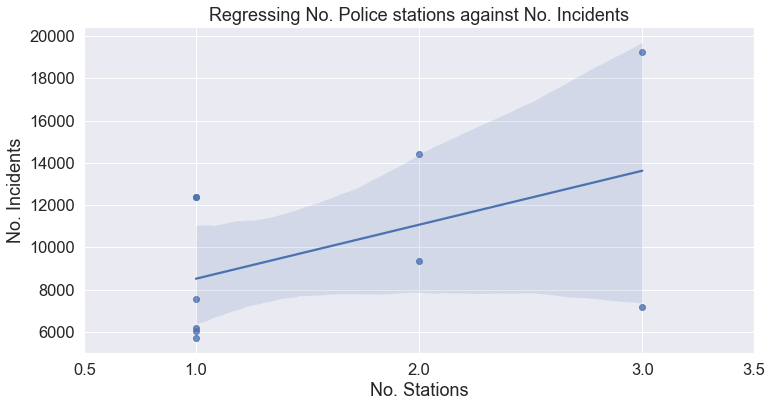

In [39]:
#Set figure size and font size of plot
sns.set(rc = {'figure.figsize':(12,6)},font_scale = 1.5)

#Create regression plot
sns.regplot(x='No. Stations',y='No. Incidents',data=reg_df,scatter=True,fit_reg=True).set(xticks=[0.5,1,2,3,3.5],title="Regressing No. Police stations against No. Incidents")

#Calculate R-Squared of the regression
Rsq=stats.pearsonr(reg_df['No. Stations'],reg_df['No. Incidents'])[0] ** 2
percentage = "{:.2%}".format(Rsq)
print("R-squared: ",percentage)

## Conclusion

1. There is no relationship between the number of police stations and nuber of crimes in San Francisco. There is a very weak positive correlation but this cannot be replied upon as there is such variance in the results (by looking at the scatter aspect of the regression plot). The R-Squared of 23.25% means the model cannot be relied upon as it is not predictive.

2. The Southern district has the highest crime rate and so should be avoided by potential buyers or movers if safety is their primary concern. 

3. The Park district is the safest area in San Francisco in terms of crime.

4. Western San Francisco is more attractive area to live in given the much lower crime rates than the more eastern districts.